In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
import os
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

In [3]:
with zipfile.ZipFile("/content/drive/MyDrive/skrapsaskripsi/fixedDataset.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset")

In [4]:
# Parameter
img_height, img_width = 224, 224  # ukuran input yang sesuai untuk MobileNetV2
batch_size = 32
num_classes = 3  # ganti sesuai jumlah kelas
epochs = 10

In [5]:
source_dir = '/content/dataset/fixedDataset'
output_dir = '/content/dataset_split'

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15


for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(output_dir, split), exist_ok=True)

# Loop ke setiap kelas
for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    # List semua file gambar
    images = os.listdir(class_path)
    random.shuffle(images)

    train_split = int(train_ratio * len(images))
    val_split = int((train_ratio + val_ratio) * len(images))

    train_images = images[:train_split]
    val_images = images[train_split:val_split]
    test_images = images[val_split:]

    # Copy file ke masing-masing folder
    for split, image_list in zip(['train', 'val', 'test'], [train_images, val_images, test_images]):
        split_class_dir = os.path.join(output_dir, split, class_name)
        os.makedirs(split_class_dir, exist_ok=True)

        for img in image_list:
            src = os.path.join(class_path, img)
            dst = os.path.join(split_class_dir, img)
            shutil.copy2(src, dst)

print("Dataset berhasil dibagi ke Train, Val, dan Test.")

Dataset berhasil dibagi ke Train, Val, dan Test.


In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    'dataset_split/train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',  # atau 'binary' jika hanya 2 kelas
    shuffle=True
)

# 2. Data Generator untuk Validation (tanpa augmentasi, hanya rescale)
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    'dataset_split/val',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# 3. Data Generator untuk Test (hanya rescale, tidak ada augmentasi)
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    'dataset_split/test',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # penting jika kamu ingin evaluasi per label atau pakai confusion matrix
)


Found 2254 images belonging to 3 classes.
Found 483 images belonging to 3 classes.
Found 485 images belonging to 3 classes.


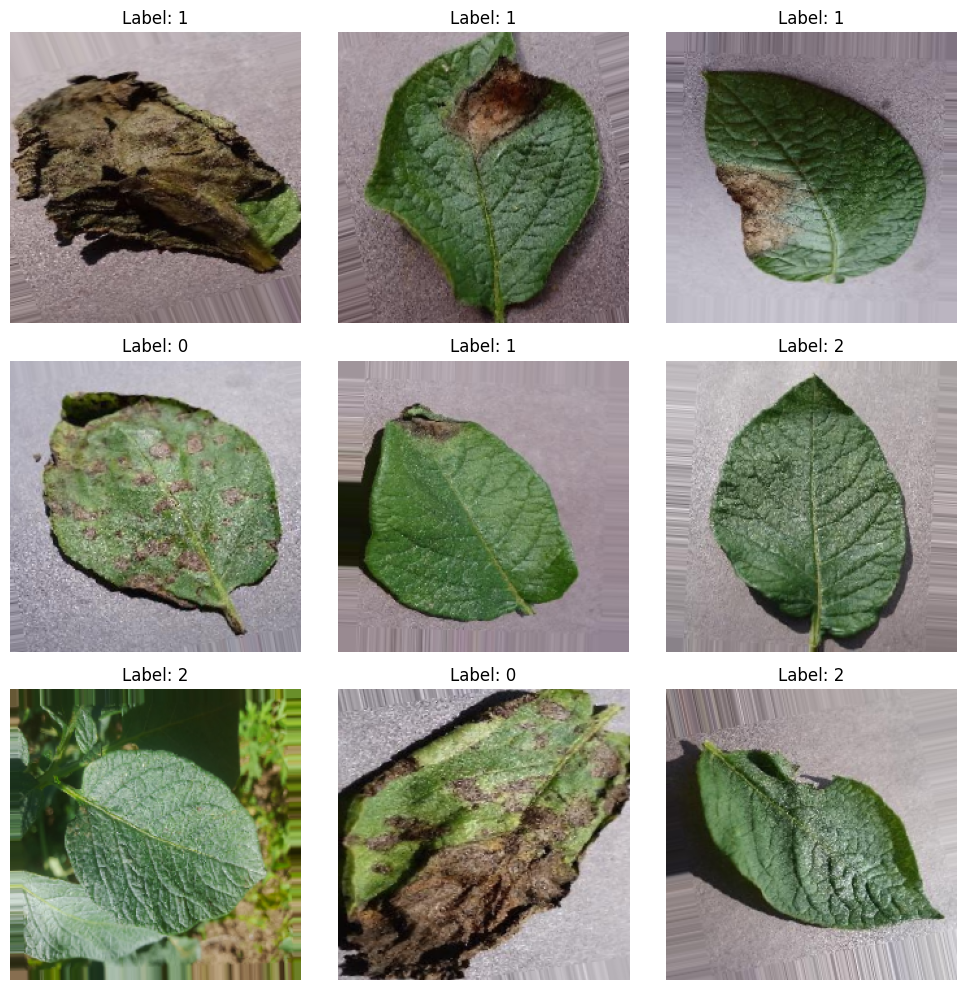

In [7]:
import matplotlib.pyplot as plt
import numpy as np
# Ambil satu batch dari train_generator
images, labels = next(train_generator)

# Tampilkan 9 gambar pertama dari batch
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"Label: {np.argmax(labels[i])}")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [8]:
base_model = MobileNetV2(weights='imagenet', include_top=False,
                         input_shape=(img_height, img_width, 3))

# Bekukan layer awal MobileNet
base_model.trainable = False

# Tambahkan top layer untuk klasifikasi
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
num_classes = 3
predictions = Dense(num_classes, activation='softmax')(x)

# Gabungkan model
model = Model(inputs=base_model.input, outputs=predictions)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [9]:
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Latih model
history = model.fit(train_generator,
          epochs=epochs,
          validation_data=val_generator)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 52s 561ms/step - accuracy: 0.6679 - loss: 0.7484 - val_accuracy: 0.9420 - val_loss: 0.2123
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 67s 438ms/step - accuracy: 0.9145 - loss: 0.2307 - val_accuracy: 0.9607 - val_loss: 0.1464
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 30s 423ms/step - accuracy: 0.9340 - loss: 0.1727 - val_accuracy: 0.9710 - val_loss: 0.1291
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 29s 412ms/step - accuracy: 0.9606 - loss: 0.1270 - val_accuracy: 0.9607 - val_loss: 0.1355
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 29s 409ms/step - accuracy: 0.9583 - loss: 0.1247 - val_accuracy: 0.9648 - val_loss: 0.1080
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 29s 412ms/step - accuracy: 0.9692 - loss: 0.1000 - val_accuracy: 0.9710 - val_loss: 0.0977
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 31s 433ms/step - accuracy: 0.9697 - loss: 0.0896 - val_accuracy: 0.9710 - val_loss: 0.0945
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 29s 414ms/step - accuracy: 0.9661 - loss: 0.0914 - val_accu

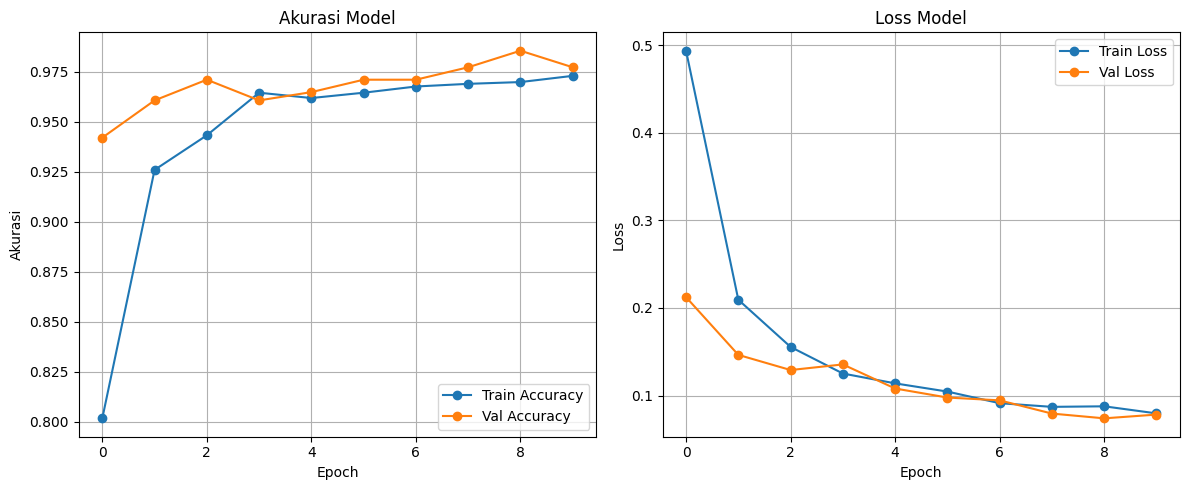

In [10]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 309ms/step


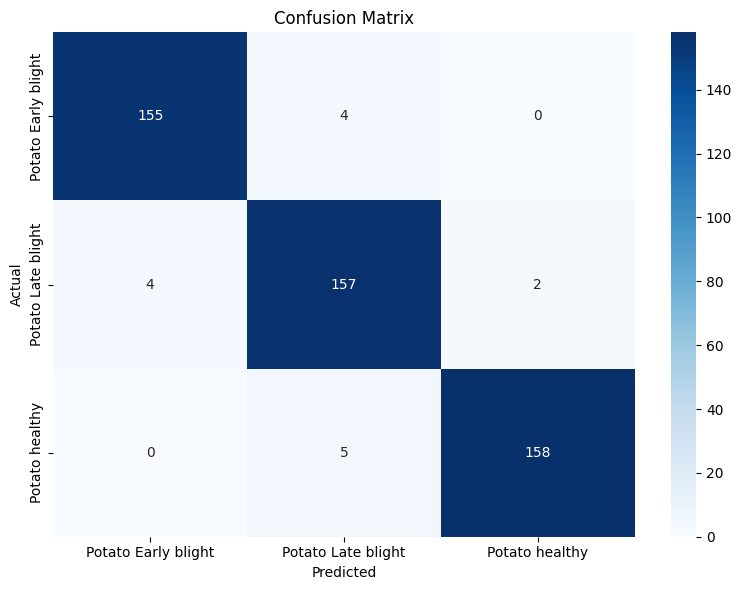

In [11]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Prediksi dari model
pred_probs = model.predict(test_generator)
y_pred = np.argmax(pred_probs, axis=1)

# Label asli dari test_generator
y_true = test_generator.classes

# Ambil nama kelas
class_names = list(test_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred)

# Plot dengan seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [15]:
def check_model_fit(history, tolerance=0.05):
    train_acc = history.history['accuracy'] # Access the 'accuracy' key directly
    val_acc = history.history['val_accuracy'] # Access the 'val_accuracy' key directly
    train_loss = history.history['loss'] # Access the 'loss' key directly
    val_loss = history.history['val_loss'] # Access the 'val_loss' key directly

    final_train_acc = train_acc[-1] * 100
    final_val_acc = val_acc[-1] * 100
    final_train_loss = train_loss[-1]
    final_val_loss = val_loss[-1]

    acc_gap = abs(final_train_acc - final_val_acc)
    loss_gap = abs(final_train_loss - final_val_loss)

    print(f"Train Accuracy: {final_train_acc:.4f}")
    print(f"Val Accuracy:   {final_val_acc:.4f}")
    print(f"Train Loss:     {final_train_loss:.4f}")
    print(f"Val Loss:       {final_val_loss:.4f}")
    print(f"Accuracy Gap:   {acc_gap:.4f}")
    print(f"Loss Gap:       {loss_gap:.4f}\n")

    if final_train_acc < 0.6 and final_val_acc < 0.6:
        print("📉 Model kemungkinan **underfitting**: akurasi train & val sama-sama rendah.")
    elif acc_gap > tolerance and final_val_acc < final_train_acc:
        print("⚠️ Model kemungkinan **overfitting**: akurasi val lebih rendah dari train.")
    elif final_val_acc > final_train_acc:
        print("✅ Model bagus! Validasi akurasi lebih tinggi dari train (bisa karena dropout/augmentasi).")
    else:
        print("✅ Model fit dengan baik. Tidak terindikasi overfitting atau underfitting yang signifikan.")

# Panggil fungsi ini setelah training:
check_model_fit(history) # Pass the 'history' dictionary

Train Accuracy: 97.2937
Val Accuracy:   97.7226
Train Loss:     0.0796
Val Loss:       0.0782
Accuracy Gap:   0.4289
Loss Gap:       0.0014

✅ Model bagus! Validasi akurasi lebih tinggi dari train (bisa karena dropout/augmentasi).


In [16]:
model.save("mobilenetv2_klasifikasi.h5")

In [29]:
# Prediksi gambar pakai model yang sudah dilatih
from tensorflow.keras.preprocessing import image
import numpy as np

img_path = '/content/early.jpg'
img = image.load_img(img_path, target_size=(224, 224))  # Adjusted target_size to (224, 224)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0  # normalisasi

prediction = model.predict(img_array)
predicted_class = np.argmax(prediction, axis=1)

# Mapping dari indeks ke nama kelas
class_indices = train_generator.class_indices
class_labels = dict((v,k) for k,v in class_indices.items())

print("Prediksi:", class_labels[predicted_class[0]])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediksi: Potato healthy
